# Automated Feature Engineering

This is a demo of the automated feature engineering framework, which has been shown to have **state-of-the-art downstream task perfromance** in experiments.

## TL;DR on AFE

AFE uses a set of **feature importance masks** to learn which features best benefit from which transformations. It uses **local** and **global masking** to determine the best transform functions for each feature, as well as which transformed features lead to an **optimal performance** with respect to the **downstream task**.

## Information required to run this notebook

What you need:
* GCP project ID
* BigQuery dataset and table names
* Training target column name (e.g. sales)
* Task type, can be classification or regression
* A GCS bucket to store AFE output. Used for displaying features in colab.

The authenticating user should have the following IAM roles:
* BigQuery Admin
* BigQuery Data Editor
* Storage Admin

A service account (can be created under “IAM & Admin”) to run the container is also needed, and the service account should have the following roles:
* Vertex AI Custom Code Service Agent
* BigQuery User
* BigQuery Data Editor



In [ ]:
# @title # Install the required dependencies
!pip install google-cloud-aiplatform --upgrade

## Import libraries
from google.cloud import storage
import json
import pandas as pd
from IPython.display import display, HTML
from google.colab import auth as google_auth
from google.api_core import exceptions


In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# @title # Authentication. { display-mode: "form"}

# @markdown The user should have the following IAM roles:
# @markdown * BigQuery Admin
# @markdown * BigQuery Data Editor
# @markdown * Storage Admin
from google.cloud import aiplatform
from google.cloud import bigquery
from google.colab import auth as google_auth

google_auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
# @title # Setting project parameters

# @markdown Specify the following BigQuery meta information: <br/>

PROJECT_ID="sungyong-internship" # @param {type:"string"}
# @markdown SERVICE_ACCOUNT: the service account should have the following roles:
# @markdown * Vertex AI Custom Code Service Agent
# @markdown * BigQuery User
# @markdown * BigQuery Data Editor
SERVICE_ACCOUNT="feature-selection@sungyong-internship.iam.gserviceaccount.com"# @param {type:"string"}
# @markdown * DATA_LOCATION refers to the region the data are located.
DATA_LOCATION="us-central1"# @param {type:"string"}

# @markdown The GCS bucket to hold AFE results.
# @markdown Must specify if want to display features below.
GCS_OUTPUT_BUCKET="feature_selection_0318"# @param {type:"string"}




In [ ]:
# @title # Setting parameters for training.

# @markdown Specify the following model parameters: <br/>

TASK_TYPE = "regression" # @param ["regression", "classification"]
FEATURE_DISCOVERY_FUNCTIONALITY = "discovery" # @param ["selection", "discovery"]

# @markdown * DATASET_NAME refers to the BigQuery dataset containing the data table.
DATASET_NAME = "kaggle_data" # @param {type:"string"}
LOGGING_FILENAME=f"{DATASET_NAME}_features.json"

# @markdown * TABLE_NAME refers to the data table to discover features on.
TABLE_NAME="CO2_emission"# @param {type:"string"}

# @markdown * TARGET refers to prediction target name.
TARGET="CO2_Emissions"# @param {type:"string"}
# @markdown * Number of learning steps:
NUM_STEPS=20 # @param {type:"integer"}

BATCH_SIZE=512
FEATURE_DIM=128
LEARNING_RATE=0.005
NUM_SELECTED_FEATURES=30


In [ ]:
# @title # Deploy the training job

# @markdown The following functions deploys the training job defined above.

def delete_gcs_feature_file():
  try:
    storage_client = storage.Client(PROJECT_ID)
    bucket = storage_client.get_bucket(GCS_OUTPUT_BUCKET)
    blob = bucket.blob(LOGGING_FILENAME)
    blob.delete()
    print(f"Existing {LOGGING_FILENAME} deleted.")
  except exceptions.NotFound as e:
    print(f"{LOGGING_FILENAME} does not exist. Nothing to delete.")

def deploy_training_job():
  aiplatform.init(project=PROJECT_ID, location=DATA_LOCATION, staging_bucket=f"gs://{GCS_OUTPUT_BUCKET}")
  training_job = {
      "display_name":"feature_selection",
      "worker_pool_specs": [
      {
          "machine_spec": {
            "machine_type": "n1-standard-16",
            "accelerator_type": "NVIDIA_TESLA_T4",
            "accelerator_count": 1
          },
          "replica_count": "1",
          "disk_spec": {
            "boot_disk_type": "pd-ssd",
            "boot_disk_size_gb": 100
          },
          "container_spec": {
            "image_uri": "us-docker.pkg.dev/vertex-ai-restricted/builtin-algorithm/afe:latest",
            "args": [f'--config={{"project_id":"{PROJECT_ID}", "dataset_name":"{DATASET_NAME}", "train_table_name":"{TABLE_NAME}", "target":"{TARGET}", "task_type":"{TASK_TYPE}","batch_size":{BATCH_SIZE}, "feature_dim":{FEATURE_DIM}, "learning_rate":{LEARNING_RATE}, "num_selected_features":{NUM_SELECTED_FEATURES}, "num_steps":{NUM_STEPS}, "model_type":"{FEATURE_DISCOVERY_FUNCTIONALITY}", "gcs_output_path":"gs://{GCS_OUTPUT_BUCKET}", "logging_filename":"{LOGGING_FILENAME}" }}']

          }
        }
      ]
  }
  job = aiplatform.CustomJob(**training_job)
  job.run(sync=True, service_account=SERVICE_ACCOUNT)
  print("Job done!")
  return job

# delete_gcs_feature_file()
job = deploy_training_job()


INFO:google.cloud.aiplatform.jobs:Creating CustomJob


kaggle_data_features.json does not exist. Nothing to delete.


INFO:google.cloud.aiplatform.jobs:CustomJob created. Resource name: projects/712758616004/locations/us-central1/customJobs/4493634787847700480
INFO:google.cloud.aiplatform.jobs:To use this CustomJob in another session:
INFO:google.cloud.aiplatform.jobs:custom_job = aiplatform.CustomJob.get('projects/712758616004/locations/us-central1/customJobs/4493634787847700480')
INFO:google.cloud.aiplatform.jobs:View Custom Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/4493634787847700480?project=712758616004
INFO:google.cloud.aiplatform.jobs:CustomJob projects/712758616004/locations/us-central1/customJobs/4493634787847700480 current state:
JobState.JOB_STATE_PENDING
INFO:google.cloud.aiplatform.jobs:CustomJob projects/712758616004/locations/us-central1/customJobs/4493634787847700480 current state:
JobState.JOB_STATE_PENDING
INFO:google.cloud.aiplatform.jobs:CustomJob projects/712758616004/locations/us-central1/customJobs/4493634787847700480 current state:
JobStat

Job submitted.


In [ ]:
# @title Retrieve Engineered Features

# @markdown The following functions retrieves and displayed engineered features.

def retrieve_features():
  # Initialise a client
  storage_client = storage.Client(PROJECT_ID)
  # Get the bucket
  bucket = storage_client.get_bucket(GCS_OUTPUT_BUCKET)
  # Get the blob
  blob = bucket.blob(LOGGING_FILENAME)
  # Download the blob as a string
  features = json.loads(blob.download_as_string())
  # Display the features
  if isinstance(features, dict):
    features_df = pd.DataFrame(features.items())
    features_df.columns = ['feature', 'score']
    html_table = features_df.to_html()
    display(HTML(html_table))
  else:
    print(features)



# Retrieving the engineered features

In addition to outputing the names of the engineered features, the pipeline also uploads the engineered features into a new BigQuery table, under the same project and dataset as the original training table. The name of the new table is a combination of the input table name, along with a time stamp when the new table is created.

An example is as follows:


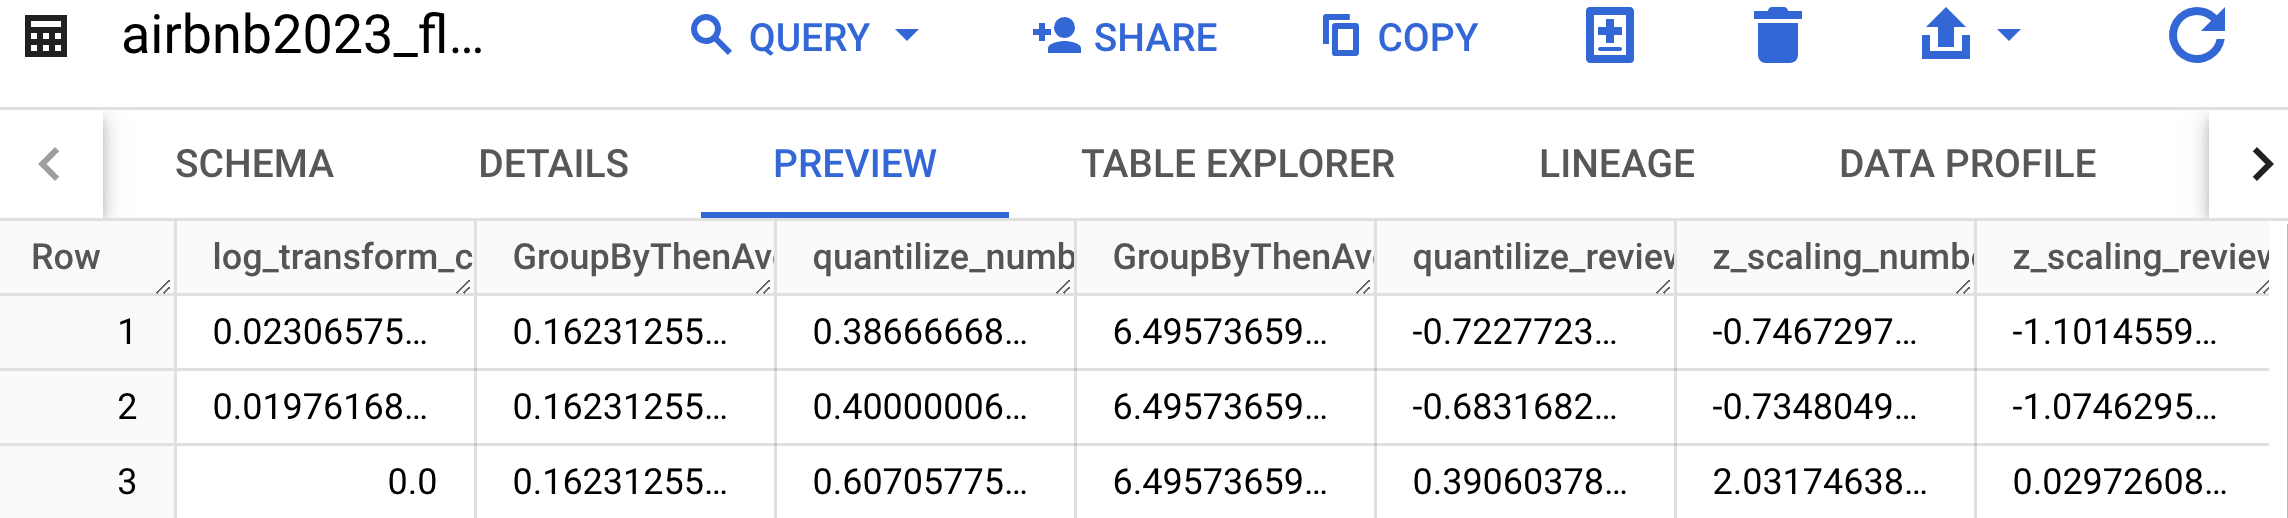

In [ ]:
retrieve_features()

,feature,score
0,"Sum(Engine_Size, Fuel_Consumption_comb_L_100km_)",0.9111157
1,log_transform(Engine_Size),0.8786785
2,log_transform(Fuel_Consumption_in_City_Hwy_L_100_km_),0.8520729
3,GroupByThenSum(Cylinders; Fuel_Consumption_comb_L_100km_),0.8102135
4,quantilize(Fuel_Consumption_in_City_L_100_km_),0.7255357
5,GroupByThenAverage(Make; Fuel_Consumption_in_City_L_100_km_),0.67406154
6,poly_transform(Fuel_Consumption_in_City_Hwy_L_100_km_),0.6694274
7,z_scaling(Fuel_Consumption_in_City_Hwy_L_100_km_),0.6422561
8,quantilize(Fuel_Consumption_comb_L_100km_),0.62388855
9,"Product(Fuel_Consumption_in_City_L_100_km_, Fuel_Consumption_comb_L_100km_)",0.61903596
